In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

import numpy as np
import scipy 
from scipy import linalg

In [2]:
# define the system parameters
m1=20  ; m2=20   ; k1=1000  ; k2=2000 ; d1=1  ; d2=5; 

# define the continuous-time system matrices
Ac=np.matrix([[0, 1, 0, 0],[-(k1+k2)/m1 ,  -(d1+d2)/m1 , k2/m1 , d2/m1 ], [0 , 0 ,  0 , 1], [k2/m2,  d2/m2, -k2/m2, -d2/m2]])
Bc=np.matrix([[0],[0],[0],[1/m2]])
Cc=np.matrix([[1, 0, 0, 0]])

In [3]:
#define an initial state for simulation
#x0=np.random.rand(2,1)
x0=np.zeros(shape=(4,1))
 
#define the number of time-samples used for the simulation and the sampling time for the discretization
time=300
sampling=0.05
 
#define an input sequence for the simulation
#input_seq=np.random.rand(time,1)
input_seq=5*np.ones(time)
#plt.plot(input_sequence)
 
I=np.identity(Ac.shape[0]) # this is an identity matrix
A=inv(I-sampling*Ac)
B=A*sampling*Bc
C=Cc
 
 
# check the eigenvalues
eigen_A=np.linalg.eig(Ac)[0]
eigen_Aid=np.linalg.eig(A)[0]

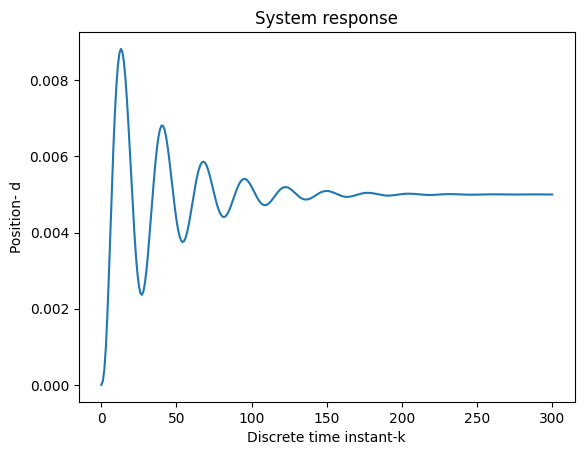

In [4]:
# the following function simulates the state-space model using the backward Euler method
# the input parameters are:
#    -- Ad,Bd,Cd           - discrete-time system matrices 
#    -- initial_state      - the initial state of the system 
#    -- time_steps         - the total number of simulation time steps 
# this function returns the state sequence and the output sequence
# they are stored in the matrices Xd and Yd respectively
def simulate(Ad,Bd,Cd,initial_state,input_sequence, time_steps):
    Xd=np.zeros(shape=(A.shape[0],time_steps+1))
    Yd=np.zeros(shape=(C.shape[0],time_steps+1))
     
    for i in range(0,time_steps):
       if i==0:
           Xd[:,[i]]=initial_state
           Yd[:,[i]]=C*initial_state
           x=Ad*initial_state+Bd*input_sequence[i]
       else:
           Xd[:,[i]]=x
           Yd[:,[i]]=C*x
           x=Ad*x+Bd*input_sequence[i]
    Xd[:,[-1]]=x
    Yd[:,[-1]]=C*x
    return Xd, Yd
     
state,output=simulate(A,B,C,x0,input_seq, time)    
 
plt.plot(output[0,:])
plt.xlabel('Discrete time instant-k')
plt.ylabel('Position- d')
plt.title('System response')
plt.savefig('step_response1.png')
plt.show()

In [ ]:
###############################################################################
# This function estimates the Markov parameters of the state-space model:
# x_{k+1} =  A x_{k} + B u_{k} + Ke(k)
# y_{k}   =  C x_{k} + e(k)
# The function returns the matrix of the Markov parameters of the model
# Input parameters:
 
# "U" - is the input vector of the form U \in mathbb{R}^{m \times timeSteps}
# "Y" - is the output vector of the form Y \in mathbb{R}^{r \times timeSteps}
# "past" is the past horizon
 
# Output parameters:
#  The problem beeing solved is
#  min_{M_pm1} || Y_p_p_l -  M_pm1 Z_0_pm1_l ||_{F}^{2}
# " M_pm1" - matrix of the Markov parameters
# "Z_0_pm1_l" - data matrix used to estimate the Markov parameters,
# this is an input parameter for the "estimateModel()" function
# "Y_p_p_l" is the right-hand side 

def estimateMarkovParameters(U,Y,past):

    timeSteps=U.shape[1]
    m=U.shape[0]
    r=Y.shape[0]
    l=timeSteps-past-1

    # data matrices for estimating the Markov parameters
    Y_p_p_l=np.zeros(shape=(r,l+1))
    Z_0_pm1_l=np.zeros(shape=((m+r)*past,l+1))  # - returned
    # the estimated matrix that is returned as the output of the function
    M_pm1=np.zeros(shape=(r,(r+m)*past))   # -returned
     
     
    # form the matrices "Y_p_p_l" and "Z_0_pm1_l"
    # iterate through columns
    for j in range(l+1):
        # iterate through rows
        for i in range(past):
            Z_0_pm1_l[i*(m+r):i*(m+r)+m,j]=U[:,i+j]
            Z_0_pm1_l[i*(m+r)+m:i*(m+r)+m+r,j]=Y[:,i+j]
        Y_p_p_l[:,j]=Y[:,j+past]
        # numpy.linalg.lstsq
        #M_pm1=scipy.linalg.lstsq(Z_0_pm1_l.T,Y_p_p_l.T)
        M_pm1=np.matmul(Y_p_p_l,linalg.pinv(Z_0_pm1_l))
     
    return M_pm1, Z_0_pm1_l, Y_p_p_l
###############################################################################
# end of function
###############################################################################


In [8]:
###############################################################################
# This function estimates the state-space model:
# x_{k+1} =  A x_{k} + B u_{k} + Ke(k)
# y_{k}   =  C x_{k} + e(k)
# Acl= A - KC
     
# Input parameters:
     
# "U" - is the input matrix of the form U \in mathbb{R}^{m \times timeSteps}
# "Y" - is the output matrix of the form Y \in mathbb{R}^{r \times timeSteps}
# "Markov" - matrix of the Markov parameters returned by the function "estimateMarkovParameters()"
# "Z_0_pm1_l" - data matrix returned by the function "estimateMarkovParameters()"      
# "past" is the past horizon
# "future" is the future horizon
# Condition: "future" <= "past"
# "order_estimate" - state order estimate
     
# Output parameters:
# the matrices: A,Acl,B,K,C
# s_singular - singular values of the matrix used to estimate the state-sequence
# X_p_p_l   - estimated state sequence    
     
     
def estimateModel(U,Y,Markov,Z_0_pm1_l,past,future,order_estimate):
    import numpy as np
    from scipy import linalg
     
    timeSteps=U.shape[1]
    m=U.shape[0]
    r=Y.shape[0]
    l=timeSteps-past-1
    n=order_estimate
     
    Qpm1=np.zeros(shape=(future*r,past*(m+r)))
    for i in range(future):
        Qpm1[i*r:(i+1)*r,i*(m+r):]=Markov[:,:(m+r)*(past-i)]
     
     
     
    # estimate the state sequence
    Qpm1_times_Z_0_pm1_l=np.matmul(Qpm1,Z_0_pm1_l)
    Usvd, s_singular, Vsvd_transpose = np.linalg.svd(Qpm1_times_Z_0_pm1_l, full_matrices=True)
    # estimated state sequence
    X_p_p_l=np.matmul(np.diag(np.sqrt(s_singular[:n])),Vsvd_transpose[:n,:])    
     
     
    X_pp1_pp1_lm1=X_p_p_l[:,1:]
    X_p_p_lm1=X_p_p_l[:,:-1]
     
    # form the matrices Z_p_p_lm1 and Y_p_p_l
    Z_p_p_lm1=np.zeros(shape=(m+r,l))
    Z_p_p_lm1[0:m,0:l]=U[:,past:past+l]
    Z_p_p_lm1[m:m+r,0:l]=Y[:,past:past+l]
     
    Y_p_p_l=np.zeros(shape=(r,l+1))
    Y_p_p_l=Y[:,past:]
         
    S=np.concatenate((X_p_p_lm1,Z_p_p_lm1),axis=0)
    ABK=np.matmul(X_pp1_pp1_lm1,np.linalg.pinv(S))
     
    C=np.matmul(Y_p_p_l,np.linalg.pinv(X_p_p_l))
    Acl=ABK[0:n,0:n]
    B=ABK[0:n,n:n+m]  
    K=ABK[0:n,n+m:n+m+r]  
    A=Acl+np.matmul(K,C)
     
     
    return A,Acl,B,K,C,s_singular,X_p_p_l
###############################################################################
# end of function
###############################################################################
